# Content 
- [Import Data](#Import-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Preprocessing](#Data-Preprocessing)
- [Tokenization](#Tokenization)
- [Multinomial Naive Bayes Classifier](#Multinomial-Naive-Bayes-Classifier)
- [Tuning Parameter by CV](#Tuning-Parameter-by-CV)
- [Model Evaluation](#Model-Evaluation)
- [Prediction](#Prediction)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_ks_statistic
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [2]:
data = pd.read_csv('../data/Disaster/train.csv', index_col = 0)
data.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
data.shape

(7613, 4)

In [4]:
data.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

# Exploratory Data Analysis

In [5]:
data['keyword'].value_counts()
# maybe just use the levels that have frequency over 30

fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [6]:
data['keyword'].value_counts()[data['keyword'].value_counts()>= 40]

fatalities     45
deluge         42
armageddon     42
body%20bags    41
sinking        41
harm           41
damage         41
collided       40
twister        40
outbreak       40
fear           40
siren          40
evacuate       40
windstorm      40
Name: keyword, dtype: int64

In [7]:
keyword_40 = data['keyword'].value_counts()[data['keyword'].value_counts()< 40].index.tolist()
keyword_40
# Filter the frequency less than 40

['wreckage',
 'whirlwind',
 'weapons',
 'wrecked',
 'earthquake',
 'hellfire',
 'famine',
 'sunk',
 'weapon',
 'collision',
 'flames',
 'explosion',
 'sinkhole',
 'derailment',
 'upheaval',
 'fatal',
 'thunder',
 'fire',
 'injury',
 'drowned',
 'flooding',
 'bombed',
 'blaze',
 'typhoon',
 'hurricane',
 'explode',
 'ambulance',
 'derailed',
 'oil%20spill',
 'deaths',
 'wreck',
 'hostages',
 'emergency',
 'crush',
 'panic',
 'blizzard',
 'wounded',
 'ruin',
 'quarantined',
 'police',
 'burning%20buildings',
 'pandemonium',
 'fatality',
 'curfew',
 'sandstorm',
 'destroy',
 'bioterror',
 'debris',
 'mudslide',
 'detonate',
 'attack',
 'displaced',
 'screaming',
 'evacuation',
 'death',
 'catastrophe',
 'dust%20storm',
 'danger',
 'tragedy',
 'massacre',
 'cliff%20fall',
 'devastation',
 'engulfed',
 'evacuated',
 'refugees',
 'ablaze',
 'nuclear%20reactor',
 'desolation',
 'floods',
 'bleeding',
 'bridge%20collapse',
 'flood',
 'tornado',
 'traumatised',
 'structural%20failure',
 'disast

In [8]:
print('keyword:', data.dropna(subset = ['keyword']).iloc[1, 0])
print('location:', data.dropna(subset = ['keyword']).iloc[1, 1])
print('text:', data.dropna(subset = ['keyword']).iloc[1, 2])
# keyword and location may not be mentioned in the text

keyword: ablaze
location: Est. September 2012 - Bristol
text: We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw


In [9]:
data['location'].value_counts()
# too much level

USA                             104
New York                         71
United States                    50
London                           45
Canada                           29
                               ... 
jersey                            1
BILASPUR,CHHATTISGARH,495001      1
@UntmdOutdoors #T.O.R.K           1
death star                        1
Baton Rouge                       1
Name: location, Length: 3341, dtype: int64

In [10]:
for i in range(10):
    print(i, data.iloc[i, 2])

0 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1 Forest fire near La Ronge Sask. Canada
2 All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3 13,000 people receive #wildfires evacuation orders in California 
4 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
5 #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
6 #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
7 I'm on top of the hill and I can see a fire in the woods...
8 There's an emergency evacuation happening now in the building across the street
9 I'm afraid that the tornado is coming to our area...


In [11]:
data['target'].value_counts()
# A bit unbalanced

0    4342
1    3271
Name: target, dtype: int64

# Data Preprocessing

In [12]:
data_rescale = data.copy()

In [13]:
data_rescale['location'] = 1 - data['location'].isna()
data_rescale.head()

,keyword,location,text,target
id,,,,
1,NaN,0,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,0,Forest fire near La Ronge Sask. Canada,1
5,NaN,0,All residents asked to 'shelter in place' are ...,1
6,NaN,0,"13,000 people receive #wildfires evacuation or...",1
7,NaN,0,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
data_rescale['location'].value_counts()

1    5080
0    2533
Name: location, dtype: int64

In [15]:
data_rescale['keyword'] = data['keyword'].replace(keyword_40, ['Others'] * len(keyword_40))
data_rescale.head()

,keyword,location,text,target
id,,,,
1,NaN,0,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,0,Forest fire near La Ronge Sask. Canada,1
5,NaN,0,All residents asked to 'shelter in place' are ...,1
6,NaN,0,"13,000 people receive #wildfires evacuation or...",1
7,NaN,0,Just got sent this photo from Ruby #Alaska as ...,1


In [16]:
data_rescale['keyword'] = data_rescale['keyword'].fillna('Not mentioned')
data_rescale.head()

,keyword,location,text,target
id,,,,
1,Not mentioned,0,Our Deeds are the Reason of this #earthquake M...,1
4,Not mentioned,0,Forest fire near La Ronge Sask. Canada,1
5,Not mentioned,0,All residents asked to 'shelter in place' are ...,1
6,Not mentioned,0,"13,000 people receive #wildfires evacuation or...",1
7,Not mentioned,0,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
data_rescale['keyword'].value_counts()

Others           6979
Not mentioned      61
fatalities         45
deluge             42
armageddon         42
sinking            41
body%20bags        41
damage             41
harm               41
windstorm          40
fear               40
siren              40
collided           40
outbreak           40
twister            40
evacuate           40
Name: keyword, dtype: int64

In [18]:
chi2_contingency(pd.crosstab(data_rescale['location'], data_rescale['target']), correction=False)
# Independent

(0.42888885897570894,
 0.5125346724399973,
 1,
 array([[1444.6717457, 1088.3282543],
        [2897.3282543, 2182.6717457]]))

In [19]:
chi2_contingency(pd.crosstab(data_rescale['keyword'], data_rescale['target']), correction=False)
# Not independent

(211.58777198080026,
 9.298604281180632e-37,
 15,
 array([[  34.79075266,   26.20924734],
        [3980.40430842, 2998.59569158],
        [  23.95428872,   18.04571128],
        [  23.38394851,   17.61605149],
        [  22.8136083 ,   17.1863917 ],
        [  23.38394851,   17.61605149],
        [  23.95428872,   18.04571128],
        [  22.8136083 ,   17.1863917 ],
        [  25.66530934,   19.33469066],
        [  22.8136083 ,   17.1863917 ],
        [  23.38394851,   17.61605149],
        [  22.8136083 ,   17.1863917 ],
        [  23.38394851,   17.61605149],
        [  22.8136083 ,   17.1863917 ],
        [  22.8136083 ,   17.1863917 ],
        [  22.8136083 ,   17.1863917 ]]))

In [20]:
temp = pd.get_dummies(data_rescale['keyword']).drop('outbreak', axis = 1)
data_rescale = pd.concat([data_rescale.drop('keyword', axis = 1), temp], axis = 1)
data_rescale.head()

,location,text,target,Not mentioned,Others,armageddon,body%20bags,collided,damage,deluge,evacuate,fatalities,fear,harm,sinking,siren,twister,windstorm
id,,,,,,,,,,,,,,,,,,
1,0,Our Deeds are the Reason of this #earthquake M...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,Forest fire near La Ronge Sask. Canada,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,All residents asked to 'shelter in place' are ...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,"13,000 people receive #wildfires evacuation or...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,Just got sent this photo from Ruby #Alaska as ...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
train, test = train_test_split(data_rescale, test_size = 0.3, random_state = 0)
train.shape, test.shape

((5329, 18), (2284, 18))

# Tokenization

In [22]:
bow = CountVectorizer().fit(train['text'])

In [23]:
def add_bow(df, model):
    temp = model.transform(df['text'])
    temp = pd.DataFrame.sparse.from_spmatrix(temp, columns = ['bow_' + i for i in model.vocabulary_.keys()], index = df.index)
    df = pd.concat([df.drop('text', axis = 1), temp], axis = 1, )
    return df

In [24]:
train_bow = add_bow(train, bow)
train_bow.head()

,location,target,Not mentioned,Others,armageddon,body%20bags,collided,damage,deluge,evacuate,...,bow_615,bow_q9lxo4qkji,bow_backs,bow_rmucfjcazr,bow_moir,bow_2sgdofsmrq,bow_xlegc6uora,bow_3934,bow_actor,bow_rossbarton
id,,,,,,,,,,,,,,,,,,,,,
686,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6913,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6066,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1441,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6365,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
test_bow = add_bow(test, bow)
test_bow.head()

,location,target,Not mentioned,Others,armageddon,body%20bags,collided,damage,deluge,evacuate,...,bow_615,bow_q9lxo4qkji,bow_backs,bow_rmucfjcazr,bow_moir,bow_2sgdofsmrq,bow_xlegc6uora,bow_3934,bow_actor,bow_rossbarton
id,,,,,,,,,,,,,,,,,,,,,
454,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7086,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
762,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9094,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1160,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Multinomial Naive Bayes Classifier

In [26]:
X = train_bow.drop(['target', 'location'], axis = 1)
y = train_bow['target']

In [27]:
mnb = MultinomialNB().fit(X, y)

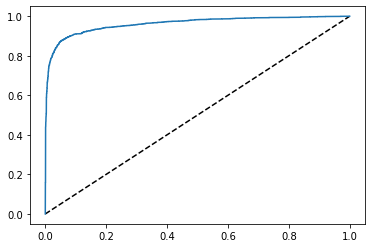

0.9614219750010741


In [28]:
fpr, tpr, _ = roc_curve(y, mnb.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

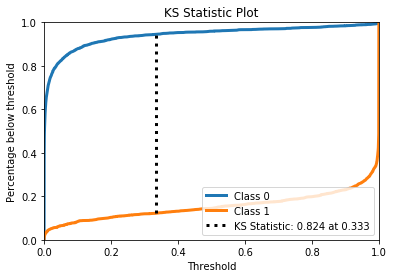

In [29]:
plot_ks_statistic(y, mnb.predict_proba(X))
plt.show()

In [30]:
confusion_matrix(y, [1 if prob >= 0.333 else 0 for prob in mnb.predict_proba(X)[:, 1]])

array([[2839,  165],
       [ 283, 2042]], dtype=int64)

In [31]:
accuracy_score(y, [1 if prob >= 0.333 else 0 for prob in mnb.predict_proba(X)[:, 1]])

0.9159316945017827

In [32]:
clf = MultinomialNB()
print(cross_val_score(clf, X, y, scoring = 'roc_auc', cv=5))
# Overfitting

[0.83336554 0.85491743 0.85391194 0.8399406  0.82594803]


# Tuning Parameter by CV

In [33]:
min_df = [0, 0.001, 0.01, 0.05]
k = 5

auc_cv = []
for train_index, test_index in KFold(n_splits = k).split(train):
    temp = []
    for df in min_df:
        train_cv = train.iloc[train_index].copy()
        test_cv = train.iloc[test_index].copy()
        bow_cv = CountVectorizer(min_df = df).fit(train_cv['text'])
        train_cv = add_bow(train_cv, bow_cv)
        test_cv = add_bow(test_cv, bow_cv)
        mnb_cv = MultinomialNB().fit(train_cv.drop(['target', 'location'], axis = 1), train_cv['target'])
        temp.append(roc_auc_score(test_cv['target'], mnb_cv.predict_proba(test_cv.drop(['target', 'location'], axis = 1))[:, 1]))
    auc_cv.append(temp)

In [34]:
auc_cv
# min_df = 0 is optimal although there is overfitting.

[[0.8323673611704097,
  0.8258385990379415,
  0.7612910226852247,
  0.6910169925710871],
 [0.8593196972781463,
  0.8616072544670759,
  0.7944484326393875,
  0.7079087691478002],
 [0.853927327171691,
  0.8501410843338804,
  0.7849705594425731,
  0.7013834902536639],
 [0.8366340166639905,
  0.8334796338917734,
  0.7646184588485075,
  0.7066120715802244],
 [0.8295477499314663,
  0.8193380369071839,
  0.7495076397004717,
  0.6701330274567516]]

# Model Evaluation

In [35]:
test_X = test_bow.drop(['target', 'location'], axis = 1)
test_y = test_bow['target']

In [36]:
accuracy_score(y, [1 if prob >= 0.333 else 0 for prob in mnb.predict_proba(X)[:, 1]])

0.9159316945017827

In [37]:
accuracy_score(test_y, [1 if prob >= 0.333 else 0 for prob in mnb.predict_proba(test_X)[:, 1]])

0.7981611208406305

In [38]:
confusion_matrix(y, [1 if prob >= 0.333 else 0 for prob in mnb.predict_proba(X)[:, 1]])

array([[2839,  165],
       [ 283, 2042]], dtype=int64)

In [39]:
confusion_matrix(test_y, [1 if prob >= 0.333 else 0 for prob in mnb.predict_proba(test_X)[:, 1]])

array([[1121,  217],
       [ 244,  702]], dtype=int64)

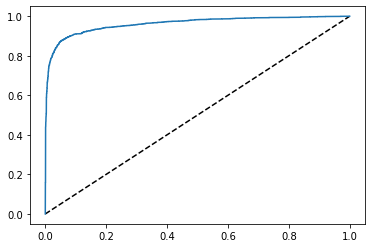

0.9614219750010741


In [40]:
fpr, tpr, _ = roc_curve(y, mnb.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

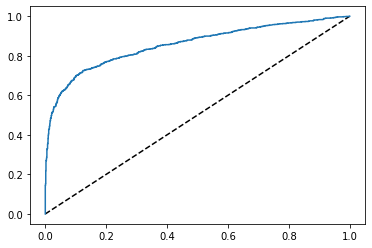

0.8561336853781321


In [41]:
fpr, tpr, _ = roc_curve(test_y, mnb.predict_proba(test_X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

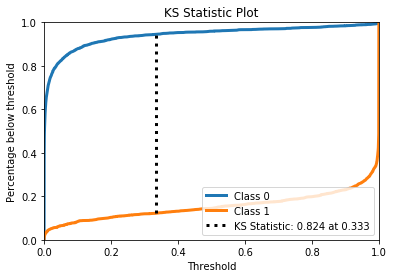

In [42]:
plot_ks_statistic(y, mnb.predict_proba(X))
plt.show()

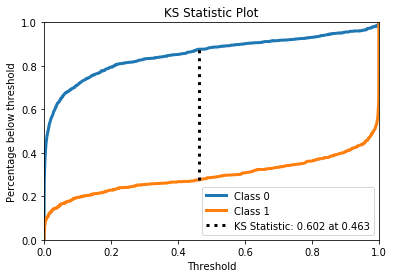

In [43]:
plot_ks_statistic(test_y, mnb.predict_proba(test_X))
plt.show()

# Prediction

In [44]:
bow = CountVectorizer().fit(data_rescale['text'])

In [45]:
data_bow = add_bow(data_rescale, bow)
data_bow.head()

,location,target,Not mentioned,Others,armageddon,body%20bags,collided,damage,deluge,evacuate,...,bow_fa3fcnln86,bow_9km,bow_5uecmcv2pk,bow_forney,bow_developing,bow_symptoms,bow_rqkk15uhey,bow_nf4iculoje,bow_stfmbbzfb5,bow_ymy4rskq3d
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
X = data_bow.drop(['target', 'location'], axis = 1)
y = data_bow['target']

In [47]:
mnb = MultinomialNB().fit(X, y)

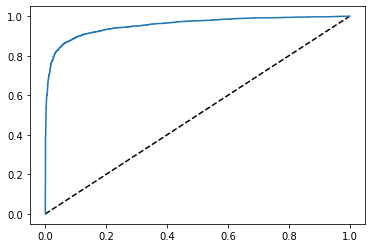

0.9554459854835868


In [48]:
fpr, tpr, _ = roc_curve(y, mnb.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

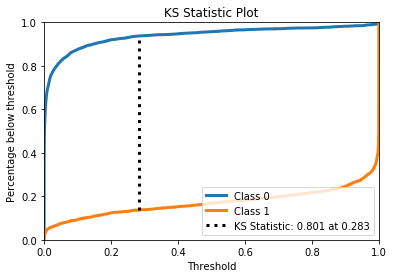

In [49]:
plot_ks_statistic(y, mnb.predict_proba(X))
plt.show()

In [50]:
accuracy_score(y, [1 if prob >= 0.283 else 0 for prob in mnb.predict_proba(X)[:, 1]])

0.905556285301458

In [51]:
confusion_matrix(y, [1 if prob >= 0.283 else 0 for prob in mnb.predict_proba(X)[:, 1]])

array([[4070,  272],
       [ 447, 2824]], dtype=int64)

In [52]:
predict = pd.read_csv('../data/Disaster/test.csv', index_col = 0)
predict.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [53]:
predict['location'] = 1 - predict['location'].isna()
predict.head()

,keyword,location,text
id,,,
0,NaN,0,Just happened a terrible car crash
2,NaN,0,"Heard about #earthquake is different cities, s..."
3,NaN,0,"there is a forest fire at spot pond, geese are..."
9,NaN,0,Apocalypse lighting. #Spokane #wildfires
11,NaN,0,Typhoon Soudelor kills 28 in China and Taiwan


In [54]:
predict['keyword'] = predict['keyword'].fillna('Not mentioned')
predict.head()

,keyword,location,text
id,,,
0,Not mentioned,0,Just happened a terrible car crash
2,Not mentioned,0,"Heard about #earthquake is different cities, s..."
3,Not mentioned,0,"there is a forest fire at spot pond, geese are..."
9,Not mentioned,0,Apocalypse lighting. #Spokane #wildfires
11,Not mentioned,0,Typhoon Soudelor kills 28 in China and Taiwan


In [55]:
predict['keyword'] = predict['keyword'].replace(keyword_40, ['Others'] * len(keyword_40))
predict.head()

,keyword,location,text
id,,,
0,Not mentioned,0,Just happened a terrible car crash
2,Not mentioned,0,"Heard about #earthquake is different cities, s..."
3,Not mentioned,0,"there is a forest fire at spot pond, geese are..."
9,Not mentioned,0,Apocalypse lighting. #Spokane #wildfires
11,Not mentioned,0,Typhoon Soudelor kills 28 in China and Taiwan


In [56]:
temp = pd.get_dummies(predict['keyword']).drop('outbreak', axis = 1)
predict = pd.concat([predict.drop('keyword', axis = 1), temp], axis = 1)
predict.head()

,location,text,Not mentioned,Others,armageddon,body%20bags,collided,damage,deluge,evacuate,fatalities,fear,harm,sinking,siren,twister,windstorm
id,,,,,,,,,,,,,,,,,
0,0,Just happened a terrible car crash,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,"Heard about #earthquake is different cities, s...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,"there is a forest fire at spot pond, geese are...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,Apocalypse lighting. #Spokane #wildfires,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,Typhoon Soudelor kills 28 in China and Taiwan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
predict = add_bow(predict, bow)
predict.head()

,location,Not mentioned,Others,armageddon,body%20bags,collided,damage,deluge,evacuate,fatalities,...,bow_fa3fcnln86,bow_9km,bow_5uecmcv2pk,bow_forney,bow_developing,bow_symptoms,bow_rqkk15uhey,bow_nf4iculoje,bow_stfmbbzfb5,bow_ymy4rskq3d
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
sample = pd.DataFrame(index = predict.index)
sample['target'] = [1 if prob >= 0.283 else 0 for prob in mnb.predict_proba(predict.drop('location', axis = 1))[:, 1]]
sample.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


In [59]:
sample.to_csv('../data/Disaster/submission.csv')

# Score in Kaggle

0.77811

# Problem

1. The model overfits to the training data as the statistics are much higher in training data than those in test data. It may be because we have too much variables. However, based on the 5-fold cross validation, without setting minimum document frequency is optimal.

# Further Work

1. The tokenization takes the most important part in the modelling. We can try different options in tokenization:  
    1.1 We can try to use n-gram for bag of word but overfitting may be more serious as we have more variables for our model.  
    1.2 We can try different tokenization method, like tf-idf and word2vec.  
    1.3 We can try to explore optimal value of other parameters for bag of word, like max_df.  
2. We converted the location into a dummy variable indicating whether the tweet provided location. But based on Pearson's goodness of fit test on contigency table, it is not significantly dependent to the target. Next time, we can try to select the top n levels from location and group the remaining levels into 'Others'.
3. This time, we only explored multinomial naive Bayes classifier. I think it is not suitable to use the models based on distance measure, like KNN. The data is a mixture of categorical variables and bag of word. It is hard to find a optimal distance function to represent the distance between different observations.